# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle
import gc


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as p
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


# Constants 

In [2]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )
ALL_DF_CSV = os.path.join(DATASET_PATH, 'all_df.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'train.csv')
TEST_DATAPATH = os.path.join(DATASET_PATH, 'test.csv')

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_train_20%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, 'cleaned_test_10%.csv')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)
    
BATCH_SIZE = 64 
MAX_SEQUENCE_LENGTH = 600
MODEL_NAME = 'prajjwal1/bert-small'

EXP_NAME = f'bertmini_amazon_max_len={MAX_SEQUENCE_LENGTH}'

# Load csv

In [3]:
train_df = pd.read_csv(CLEANED_TRAIN_DATAPATH)
train_df.drop('title', axis =1 , inplace=True)
train_df.dropna(inplace=True)

NUM_CLASSES = len(train_df['review'].unique())

# check data quality

print(train_df.isna().sum())

print("num class = ", NUM_CLASSES)
print(train_df.shape)

train_df.head()


review    0
text      0
dtype: int64
num class =  5
(599957, 2)


,review,text
0,1,they tried to do their own take on some of the...
1,0,this movie tried really hard to copy the ring ...
2,0,i did not really like montana because it was a...
3,3,recently saw ann in person with the cleveland ...
4,1,i am sorry but i just do not agree with all th...


In [4]:
test_df = pd.read_csv(CLEANED_TEST_DATAPATH)
test_df.drop('title', axis =1 , inplace=True)
test_df.dropna(inplace=True)
TEST_NUM_CLASSES = len(test_df['review'].unique())
print(test_df.isna().sum())
print("num class = ", TEST_NUM_CLASSES)
print(test_df.shape)
test_df.head()

review    0
text      0
dtype: int64
num class =  5
(64993, 2)


,review,text
0,3,clfford odets play with a lot of depression an...
1,3,when the cure s oeuvre is finally done and thi...
2,3,the second album from this accomplished young ...
3,0,i bought this product because of the high rati...
4,2,these are your normal really cheap in earphone...


# Dataset

In [5]:
class AmazonReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df['text'].iloc[idx]
        label = self.df['review'].iloc[idx]
#         print('idx', idx)

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            # pad_to_max_length = True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids = pad_sequence(input_ids, batch_first=True)
    attention_mask = pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# BERT pretrained

In [6]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [7]:
# train_dataset = AmazonReviewDataset(train_df, tokenizer)
# print(len(train_dataset))

# with open(AMAZON_DATASET_SAVEPATH, 'wb') as file:
#     pickle.dump(all_dataset, file)

In [8]:
# indices = [3332, 8107, 69566, 25697, 86807, 26598, 37591, 29156]

# # Iterate over each index and print the required information
# for idx in indices:
#     if idx in train_df.index:  # Check if the index exists in the DataFrame
#         text = train_df['text'][idx]
#         target = train_df['target'][idx]
#         text_length = len(text)
#         print(f"Index {idx}:")
#         print(f"Text: {text}")
#         print(f"Length of Text: {text_length}")
#         print(f"Target: {target}\n")
#     else:
#         print(f"Index {idx} not in DataFrame.\n")


# Create dataset and dataloader

In [9]:
total_train_len = len(train_df)
train_len = int(0.9 * total_train_len) 
val_len = total_train_len - train_len

train_dataset = AmazonReviewDataset(train_df, tokenizer, max_length=MAX_SEQUENCE_LENGTH)
test_dataset = AmazonReviewDataset(test_df, tokenizer, max_length=MAX_SEQUENCE_LENGTH)

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print('train dataloader = ', len(train_dataloader))
print('valid dataloader = ', len(val_dataloader))
print('test dataloader = ', len(test_dataloader))

sample = next(iter(train_dataloader))
print('sample input ids = ', sample['input_ids'].shape)
print('sample attention mask = ', sample['attention_mask'].shape)
print('sample label shape = ', sample['labels'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


train dataloader =  8437
valid dataloader =  938
test dataloader =  1016
sample input ids =  torch.Size([64, 191])
sample attention mask =  torch.Size([64, 191])
sample label shape =  torch.Size([64])


# Training utils

In [10]:
def get_gpu_free_mem():
    free, total = torch.cuda.mem_get_info()
    mem_free = (free/total)
    return mem_free

In [11]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
def get_accuracy(predictions, labels):
    return (predictions == labels).sum() / len(labels)

def train(dataloader, model, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    loop = tqdm(dataloader, desc="training...")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(loss.detach().cpu().item())
        epoch_accs.append(accuracy.detach().cpu().item())
        #release GPU memory if available % < 2% --> free mem

        free_mem = get_gpu_free_mem()
        if  free_mem < 0.3:
            gc.collect()
            torch.cuda.empty_cache()
        
        loop.set_description(f"free_mem = {free_mem:.2f}")

    gc.collect()
    torch.cuda.empty_cache()

    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc="evaluating..."):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(output.loss.item())
        epoch_accs.append(accuracy.item())

        free_mem = get_gpu_free_mem()
        if  free_mem < 0.3:
            gc.collect()
            torch.cuda.empty_cache()

    gc.collect()
    torch.cuda.empty_cache()
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def plot(history, save_fig = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))

    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_fig:
        plt.savefig(save_fig)
    if show:
        plt.show()
    plt.clf()

def tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader, epochs = 10, label = 'baseline', history = None):
    SAVE_PATH = os.path.join(OUTPUT_PATH, label)
    PLOT_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    best_valid_loss = float("inf")
    if history == None:
        history = collections.defaultdict(list)

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, device)
        test_loss, test_acc = evaluate(test_dataloader, model, device)

        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss 
            torch.save(model, os.path.join(SAVE_PATH, 'bert.checkpoint.torch'))

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

        plot(history, save_fig=PLOT_PATH)

        with open(os.path.join(SAVE_PATH, 'history.pickle'), 'wb') as file:
            pickle.dump(history, file)

    
    plot(history, show=True)

    



# Tune

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA Device Name: NVIDIA GeForce RTX 3060


evaluating...: 100%|██████████| 1016/1016 [03:03<00:00,  5.53it/s]


epoch: 0
train_loss: 1.040, train_acc: 0.544
val_loss: 0.984, valid_acc: 0.574
test_loss: 0.988, test_acc: 0.573


evaluating...: 100%|██████████| 1016/1016 [03:05<00:00,  5.49it/s]


epoch: 1
train_loss: 0.936, train_acc: 0.592
val_loss: 0.982, valid_acc: 0.580
test_loss: 0.985, test_acc: 0.579


evaluating...: 100%|██████████| 1016/1016 [03:03<00:00,  5.53it/s]


epoch: 2
train_loss: 0.866, train_acc: 0.625
val_loss: 1.012, valid_acc: 0.573
test_loss: 1.013, test_acc: 0.575


evaluating...: 100%|██████████| 1016/1016 [03:04<00:00,  5.50it/s]


epoch: 3
train_loss: 0.796, train_acc: 0.660
val_loss: 1.082, valid_acc: 0.567
test_loss: 1.084, test_acc: 0.564


evaluating...: 100%|██████████| 1016/1016 [03:05<00:00,  5.48it/s]


epoch: 4
train_loss: 0.725, train_acc: 0.694
val_loss: 1.139, valid_acc: 0.559
test_loss: 1.143, test_acc: 0.557


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

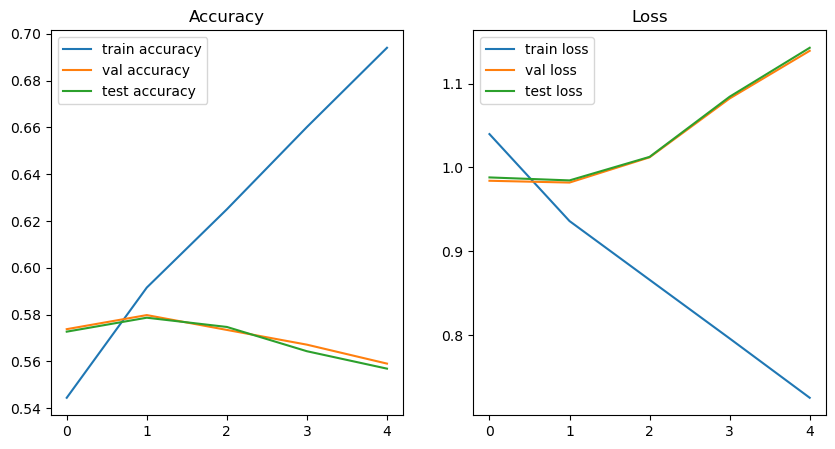

<Figure size 640x480 with 0 Axes>

In [13]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay = 0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print("CUDA Device Name:", device_name)
training_epochs = 5

tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader,
      epochs = training_epochs, label = 'tiny_bert_10%_amazon_256_max_len')

# Journal

- processing the data on the fly like what AmazonReviewDataset is doing yields low GPU and CPU ultilization
- overfits in test set. Try applying regularization, increased train size, reduced test size. (maybe because bert-tiny is not enough)
- how to release GPU memory after each iteration? 